### Imports

In [633]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt

In [634]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f3, f4, f5]
dfs = [df1, df3, df4, df5]
Hfs = [Hf1, Hf3, Hf4, Hf5]
fnames = ["f1", "f3", "f4", "f5"]

In [635]:
def projected_gradient_norm(Q, b, x):
    grad = Q @ x + b
    x_norm_sq = np.dot(x, x)
    M = np.eye(len(x)) - np.outer(x, x) / x_norm_sq
    proj_grad = M @ grad
    return np.linalg.norm(proj_grad)

In [ ]:
def alg12(Q, b, delta, epsilon=1e-8):
    proj_grads = []
    stopping_criteria_list = []
    def p(lambd):
        return -np.linalg.inv(Q + lambd * np.identity(Q.shape[0])).dot(b)
    
    lambda1 = np.linalg.eigvalsh(Q)[0]
    

    if lambda1 > 0 and np.linalg.norm(p(0)) <= delta:
        return p(0), [0], [0]
    
    l = max(0, -lambda1)
    u = max(0, -lambda1) + 1
    
    while np.linalg.norm(p(u)) > delta:
        l = u
        u = 2 * u
    
    while True:
        lambdaMark = 0.5 * (l + u)
        pMark = p(lambdaMark)
        stopping_criteria_list.append(abs(np.linalg.norm(pMark) - delta))
        proj_grad = projected_gradient_norm(Q, b, pMark)
        proj_grads.append(proj_grad)

        if np.linalg.norm(pMark) < delta and abs(np.linalg.norm(pMark) - delta) < epsilon:
            return pMark, proj_grads, stopping_criteria_list
        
        if np.linalg.norm(pMark) > delta:
            l = lambdaMark
        else:
            u = lambdaMark


In [651]:
def generate_problem(n, Q_type='posdef', feasibility='feasible'):
    A = np.random.randn(n, n)
    Q = A.T @ A
    if Q_type == 'negdef':
        Q = -Q

    if feasibility == 'feasible':
        x_star = np.random.randn(n) * 0.5
        delta = np.linalg.norm(x_star) + 0.1 
    elif feasibility == 'infeasible':
        x_star = np.random.randn(n) * 3.0
        delta = np.linalg.norm(x_star) * 0.7
    else:
        raise ValueError("feasibility must be 'feasible' or 'infeasible'")

    b = -Q @ x_star
    return Q, b, delta, x_star


In [ ]:
n = 5
num_runs = 400
def test_all_cases():
    posdef_infeasible = []
    negdef_feasible = []
    negdef_infeasible = []

    for i in range(num_runs):
        Q, b, delta, x_star = generate_problem(n, Q_type='posdef', feasibility='infeasible')
        
        start_time = time.time()
        x_sol, proj_grads, stopping_criteria_list = alg12(Q, b, delta)
        end_time = time.time()
        
        x_star_norm = np.linalg.norm(x_star)
        x_sol_norm = np.linalg.norm(x_sol)
        final_proj_grad = proj_grads[-1]

        iters = len(stopping_criteria_list)-1
        duration = end_time-start_time
        posdef_infeasible.append(('posdef', 'infeasible', Q, b, delta, x_star_norm, x_sol_norm, proj_grads, final_proj_grad, stopping_criteria_list, stopping_criteria_list[-1], iters, duration))
    
    for i in range(num_runs):
        Q, b, delta, x_star = generate_problem(n, Q_type='negdef', feasibility='feasible')
        
        start_time = time.time()
        x_sol, proj_grads, stopping_criteria_list = alg12(Q, b, delta)
        end_time = time.time()
        
        x_star_norm = np.linalg.norm(x_star)
        x_sol_norm = np.linalg.norm(x_sol)
        final_proj_grad = proj_grads[-1]

        iters = len(stopping_criteria_list)-1
        duration = end_time-start_time
        negdef_feasible.append(('negdef', 'feasible', Q, b, delta, x_star_norm, x_sol_norm, proj_grads, final_proj_grad, stopping_criteria_list, stopping_criteria_list[-1], iters, duration))
    
    for i in range(num_runs):
        Q, b, delta, x_star = generate_problem(n, Q_type='negdef', feasibility='infeasible')
        
        start_time = time.time()
        x_sol, proj_grads, stopping_criteria_list = alg12(Q, b, delta)
        end_time = time.time()

        x_star_norm = np.linalg.norm(x_star)
        x_sol_norm = np.linalg.norm(x_sol)
        final_proj_grad = proj_grads[-1]

        iters = len(stopping_criteria_list)-1
        duration = end_time-start_time
        negdef_infeasible.append(('negdef', 'infeasible', Q, b, delta, x_star_norm, x_sol_norm, proj_grads, final_proj_grad, stopping_criteria_list, stopping_criteria_list[-1], iters, duration))
    


    columns = ["Q_type", "Feasibility", "Q", "b", "delta", "||x_star||", "||x_sol||", "Projected Gradients", "Final Projected Gradient", "Progress", "Final", "Iterations", "Time"]

    df_posdef_infeasible = pd.DataFrame(posdef_infeasible, columns=columns)
    df_negdef_feasible = pd.DataFrame(negdef_feasible, columns=columns)
    df_negdef_infeasible = pd.DataFrame(negdef_infeasible, columns=columns)

    df_display_posdef_infeasible = df_posdef_infeasible.drop(columns=["Q", "b", "Projected Gradients", "Final Projected Gradient", "Progress", "Iterations", "Time"])
    df_display_negdef_feasible = df_negdef_feasible.drop(columns=["Q", "b", "Projected Gradients", "Final Projected Gradient", "Progress", "Iterations", "Time"])
    df_display_negdef_infeasible = df_negdef_infeasible.drop(columns=["Q", "b", "Projected Gradients", "Final Projected Gradient", "Progress", "Iterations", "Time"])

    results = [[df_posdef_infeasible, df_display_posdef_infeasible], [df_negdef_feasible, df_display_negdef_feasible], [df_negdef_infeasible, df_display_negdef_infeasible]]

    return results


In [639]:
results = test_all_cases()

tools.display_dataframe_to_user(name="Benchmark Results", dataframe=results[0][1])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=results[1][1])
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=results[2][1])

Benchmark Results


Benchmark Results


Benchmark Results


In [640]:
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=results[2][0])



Benchmark Results


In [641]:
df_avg_results_pi = (results[0][0]).agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final": "mean"
})

df_avg_results_nf = results[1][0].agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final": "mean"
})

df_avg_results_ni = results[2][0].agg({
    "Iterations": "mean",
    "Time": "mean",
    "Final": "mean"
}).reset_index()


tools.display_dataframe_to_user(name="Positive definite - Infeasible", dataframe=df_avg_results_pi)
tools.display_dataframe_to_user(name="Negative definite - Feasible", dataframe=df_avg_results_nf)
tools.display_dataframe_to_user(name="Negative definite - Infeasible", dataframe=df_avg_results_ni)

Positive definite - Infeasible


Negative definite - Feasible


Negative definite - Infeasible


In [642]:
def pad_progress_list(list):
    max_length_run = max(len(run) for run in list)
    #print(max_length_run)
    padded_runs = []

    for run in list:
        padded_run = np.pad(run, (0, max_length_run - len(run)), mode="constant", constant_values=0)
        padded_runs.append(padded_run)
    
    return padded_runs

progress1 = results[0][0]["Progress"]
progress2 = results[1][0]["Progress"]
progress3 = results[2][0]["Progress"]

padded_progress1 = pad_progress_list(progress1)
padded_progress2 = pad_progress_list(progress2)
padded_progress3 = pad_progress_list(progress3)

mean_padded_progress1  = np.mean(padded_progress1, axis=0)
mean_padded_progress2  = np.mean(padded_progress2, axis=0)
mean_padded_progress3  = np.mean(padded_progress3, axis=0)

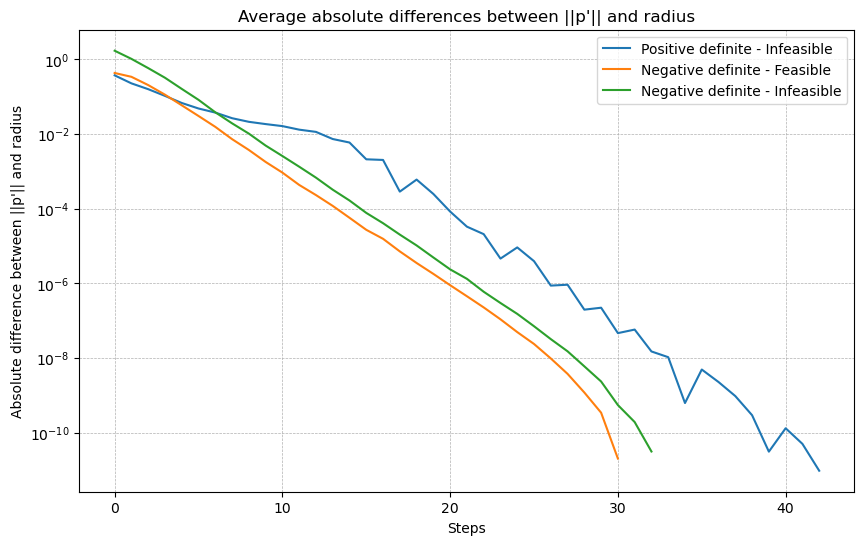

In [643]:

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_padded_progress1)), mean_padded_progress1, label="Positive definite - Infeasible")
plt.plot(range(len(mean_padded_progress2)), mean_padded_progress2, label="Negative definite - Feasible")
plt.plot(range(len(mean_padded_progress3)), mean_padded_progress3, label="Negative definite - Infeasible")

plt.xlabel("Steps")
plt.ylabel("Absolute difference between ||p'|| and radius")
plt.title("Average absolute differences between ||p'|| and radius")
plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


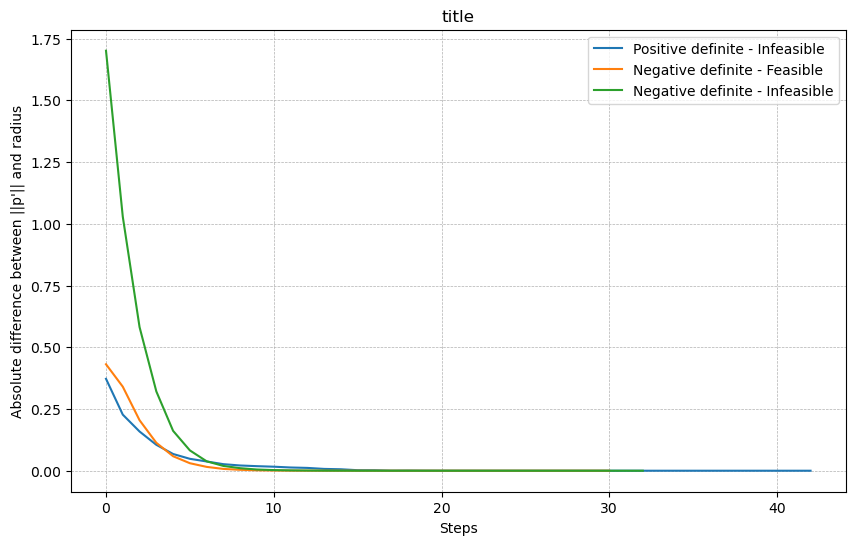

In [644]:

plt.figure(figsize=(10, 6))
plt.plot(range(len(mean_padded_progress1)), mean_padded_progress1, label="Positive definite - Infeasible")
plt.plot(range(len(mean_padded_progress2)), mean_padded_progress2, label="Negative definite - Feasible")
plt.plot(range(len(mean_padded_progress3)), mean_padded_progress3, label="Negative definite - Infeasible")

plt.xlabel("Steps")
plt.ylabel("Absolute difference between ||p'|| and radius")
plt.title('title')
# plt.yscale("log")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()
